### 1 - Import test data

In [34]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("^RUI.csv")
df=df[df.High!=df.Low]
df = df.dropna(subset=['Close'])
df.reset_index(inplace=True, drop=True)

In [35]:
df["EMA"]=ta.ema(df.Close, length=300)
df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=14)


my_bbands = ta.bbands(df.Close, length=200, std=4)
df=df.join(my_bbands)

my_bbands = ta.bbands(df.Close, length=200, std=0.5)
df=df.join(my_bbands)

df['BBUP_EMA'] = df['EMA'] + 4 * df['EMA'].rolling(200).std()
df['BBUP_Close'] = df['EMA'] + 4 * df['Close'].rolling(200).std()
df['BBUP_MidPrice'] = df['EMA'] + 4 * ((df['Close']+df['Open']+df['High'])/3).rolling(200).std()

df['BBDN'] = df['EMA'] - 0.5 * df['Close'].rolling(200).std()
df.loc[(df['Close'] < df['BBDN']), 'EXIT'] = 1

df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA,ATR,BBL_200_4.0,...,BBL_200_0.5,BBM_200_0.5,BBU_200_0.5,BBB_200_0.5,BBP_200_0.5,BBUP_EMA,BBUP_Close,BBUP_MidPrice,BBDN,EXIT
0,2010-01-25,600.099976,606.030029,600.099976,602.820007,602.820007,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-26,602.809998,606.549988,598.989990,600.349976,600.349976,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-27,600.320007,604.010010,595.070007,602.950012,602.950012,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-28,602.909973,604.429993,592.320007,595.640015,595.640015,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-29,595.630005,602.219971,588.229980,589.409973,589.409973,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,2024-05-20,2904.000000,2915.080078,2903.379883,2906.379883,2906.379883,0.0,2562.368481,24.835906,1850.046038,...,2504.782128,2598.315856,2691.849583,7.199566,2.146807,2901.247809,3312.516017,3310.136357,2468.600038,NaN
3604,2024-05-21,2903.040039,2913.399902,2900.409912,2912.179932,2912.179932,0.0,2564.692809,23.989769,1848.201986,...,2506.545572,2600.594656,2694.643740,7.232891,2.156504,2905.895516,3318.973544,3316.641558,2470.407717,NaN
3605,2024-05-22,2910.820068,2912.600098,2892.169922,2903.159912,2903.159912,0.0,2566.941760,23.735512,1846.325001,...,2508.172555,2602.722206,2697.271856,7.265443,2.088783,2910.483664,3325.237079,3322.893238,2472.154845,NaN
3606,2024-05-23,2910.179932,2920.850098,2874.179932,2879.699951,2879.699951,0.0,2569.019887,25.373702,1845.381254,...,2509.865618,2604.791956,2699.718293,7.288593,1.948007,2914.907110,3330.336265,3328.613301,2473.855340,NaN


In [36]:
import pandas as pd

def ema_signals(df, backcandles=2):
    """
    Calculate signals based on EMA conditions.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - backcandles: Number of previous candles to consider for the condition.

    Returns:
    - None. The signals are added directly to the input DataFrame.
    """
    # Ensure the DataFrame has columns for 'Close', 'EMA', and 'Signal'
    required_columns = ['Close', 'EMA']
    assert all(col in df.columns for col in required_columns), \
        "DataFrame must contain 'Close' and 'EMA' columns."

    # Initialize the 'Signal' column with default values (0)
    df['Signal'] = 0

    # Iterate over the DataFrame rows starting from the index equal to 'backcandles'
    for i in range(backcandles, len(df)):
        # Extract the relevant data for the current and previous candles
        previous_closes = df.iloc[i-backcandles:i+1]['Close'].values # i+1 to include current candle (no lookahead)
        ema_values = df.iloc[i-backcandles:i+1]['EMA'].values # i+1 to include current candle (no lookahead)

        # Check if all previous closes are above the corresponding EMA values
        if all(close > ema for close, ema in zip(previous_closes, ema_values)):
            df.at[i, 'EMASignal'] = 2

# Example usage
# Assuming df is your DataFrame and it already contains 'Close' and 'EMA' columns
ema_signals(df, backcandles=5)
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA,ATR,BBL_200_4.0,...,BBU_200_0.5,BBB_200_0.5,BBP_200_0.5,BBUP_EMA,BBUP_Close,BBUP_MidPrice,BBDN,EXIT,Signal,EMASignal
0,2010-01-25,600.099976,606.030029,600.099976,602.820007,602.820007,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2010-01-26,602.809998,606.549988,598.989990,600.349976,600.349976,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2010-01-27,600.320007,604.010010,595.070007,602.950012,602.950012,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,2010-01-28,602.909973,604.429993,592.320007,595.640015,595.640015,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2010-01-29,595.630005,602.219971,588.229980,589.409973,589.409973,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,2024-05-20,2904.000000,2915.080078,2903.379883,2906.379883,2906.379883,0.0,2562.368481,24.835906,1850.046038,...,2691.849583,7.199566,2.146807,2901.247809,3312.516017,3310.136357,2468.600038,NaN,0,2.0
3604,2024-05-21,2903.040039,2913.399902,2900.409912,2912.179932,2912.179932,0.0,2564.692809,23.989769,1848.201986,...,2694.643740,7.232891,2.156504,2905.895516,3318.973544,3316.641558,2470.407717,NaN,0,2.0
3605,2024-05-22,2910.820068,2912.600098,2892.169922,2903.159912,2903.159912,0.0,2566.941760,23.735512,1846.325001,...,2697.271856,7.265443,2.088783,2910.483664,3325.237079,3322.893238,2472.154845,NaN,0,2.0
3606,2024-05-23,2910.179932,2920.850098,2874.179932,2879.699951,2879.699951,0.0,2569.019887,25.373702,1845.381254,...,2699.718293,7.288593,1.948007,2914.907110,3330.336265,3328.613301,2473.855340,NaN,0,2.0


In [37]:
def add_total_signal(df):
    """
    Adds a new column 'TotalSignal' to the DataFrame based on conditions.

    Parameters:
    - df: pandas.DataFrame containing the data.

    Returns:
    - None. The 'TotalSignal' column is added directly to the input DataFrame.
    """
    # Define the condition for adding 'TotalSignal'
    #df['TotalSignal'] = df.apply(lambda row: 2 if row['EMASignal'] == 2 and row['Close'] > row['BBU_200_4.0'] else 0, axis=1)
    df['TotalSignal'] = df.apply(lambda row: 2 if row['EMASignal'] == 2 and row['Close'] > row['BBUP_EMA'] else 0, axis=1)

add_total_signal(df)

In [38]:
df.loc[1210:1250, ["EMA", "BBUP_Close", "BBUP_EMA", "BBU_200_4.0", "BBUP_MidPrice"]]

,EMA,BBUP_Close,BBUP_EMA,BBU_200_4.0,BBUP_MidPrice
1210,1038.061895,1176.911944,1182.624066,1209.715140,1175.225985
1211,1038.694042,1177.271015,1183.046450,1210.095448,1175.559079
1212,1039.324513,1177.329320,1183.464854,1210.210213,1175.686891
1213,1039.953520,1176.110360,1183.873671,1209.172723,1175.225068
1214,1040.618613,1175.516111,1184.313250,1208.712783,1174.361910
1215,1041.266130,1174.628446,1184.728676,1207.977493,1173.444840
1216,1041.926953,1174.433350,1185.153939,1207.872216,1172.887652
1217,1042.622455,1175.063593,1185.614446,1208.520121,1173.305895
1218,1043.337721,1175.889179,1186.096171,1209.352566,1173.973392
1219,1044.040926,1177.031263,1186.569363,1210.452696,1175.014097


In [39]:
df["TotalSignal"].value_counts()

TotalSignal
0    2779
2     829
Name: count, dtype: int64

In [40]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-4
    elif x['TotalSignal']==1:
        return x['High']+1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

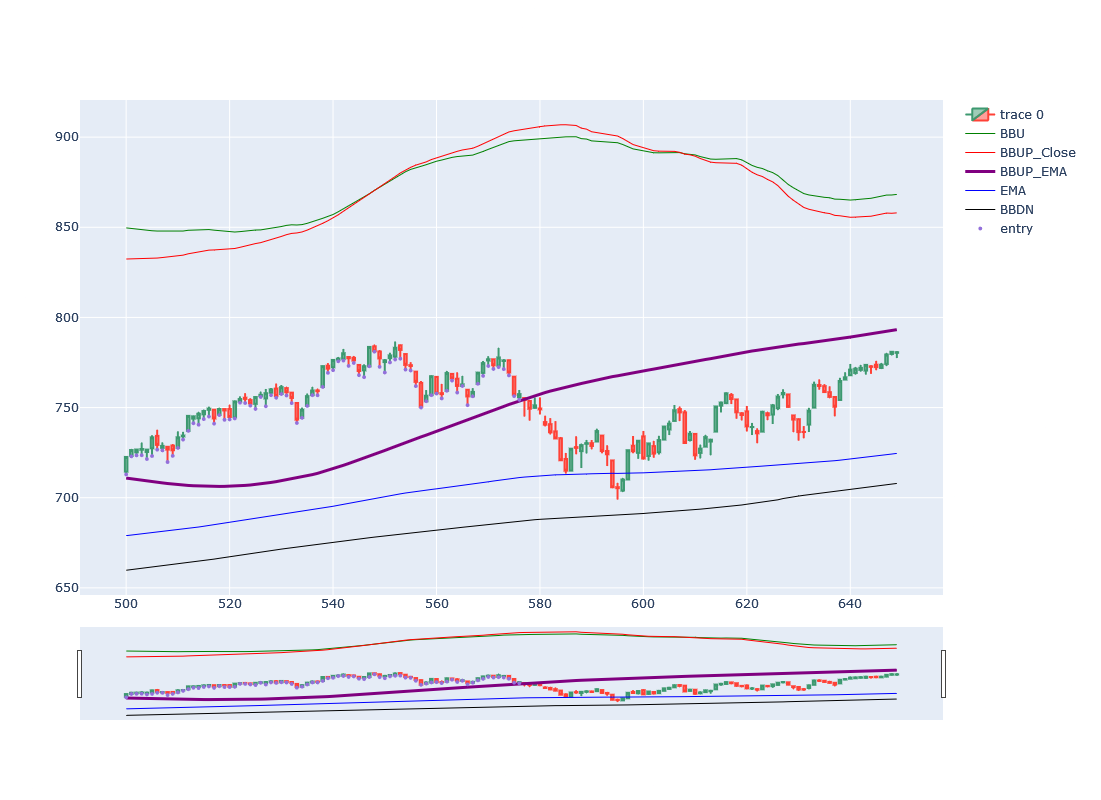

In [41]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=500
dfpl = df[st:st+150]
# Create a plot with 2 rows
fig = make_subplots(rows=1, cols=1)

# Add candlestick plot on the first row
fig.add_trace(go.Candlestick(x=dfpl.index,
                             open=dfpl['Open'],
                             high=dfpl['High'],
                             low=dfpl['Low'],
                             close=dfpl['Close']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['BBU_200_4.0'],
                         line=dict(color='green', width=1),
                         name="BBU"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['BBUP_Close'],
                         line=dict(color='red', width=1),
                         name="BBUP_Close"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['BBUP_EMA'],
                         line=dict(color='purple', width=3),
                         name="BBUP_EMA"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['EMA'],
                         line=dict(color='blue', width=1),
                         name="EMA"),
              row=1, col=1)

fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['BBDN'],
                         line=dict(color='black', width=1),
                         name="BBDN"),
              row=1, col=1)

# Add markers for trade entry points on the same subplot
fig.add_trace(go.Scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                         marker=dict(size=4, color="MediumPurple"),
                         name="entry"),
              row=1, col=1)

fig.update_layout(width=1200, height=800, sliders=[])
fig.show()

In [43]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[0:].copy()
dfopt["Date"] = pd.to_datetime(dfopt["Date"])
dfopt.set_index(["Date"], inplace=True)

def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    trailperc = 0.02
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        

    def next(self):
        super().next()
        
        sltr = self.data.Close[-1]*self.trailperc

        for trade in self.trades: 
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - sltr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + sltr) 
     
        if self.signal1==2 and len(self.trades)==0:
            self.buy(sl=sltr, size=self.mysize)
        
bt = Backtest(dfopt, MyStrat, cash=100000, margin=1/5, commission=0.05)
stats, heatmap = bt.optimize(trailperc=[i/100 for i in range(1, 20)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

Start                     2010-01-25 00:00:00
End                       2024-05-24 00:00:00
Duration                   5233 days 00:00:00
Exposure Time [%]                   62.998891
Equity Final [$]                162257.451036
Equity Peak [$]                 162978.952506
Return [%]                          62.257451
Buy & Hold Return [%]              381.050742
Return (Ann.) [%]                    3.438377
Volatility (Ann.) [%]                5.638209
Sharpe Ratio                         0.609835
Sortino Ratio                        0.843051
Calmar Ratio                         0.316248
Max. Drawdown [%]                  -10.872402
Avg. Drawdown [%]                   -0.938388
Max. Drawdown Duration     1056 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                    5
Win Rate [%]                            100.0
Best Trade [%]                      41.046975
Worst Trade [%]                      0.482926
Avg. Trade [%]                    

In [22]:
stats["_strategy"]
heatmap

trailperc
0.01        -93.056506
0.02        -71.666447
0.03        -45.761075
0.04        -28.790514
0.05        -16.167032
0.06         -5.459826
0.07         19.966370
0.08         19.458593
0.09         36.454324
0.10         35.416350
0.11         62.257451
0.12         60.191400
0.13         56.248128
0.14         52.665382
0.15         48.647376
0.16         45.006608
0.17         59.877813
0.18         56.753104
0.19         53.566985
Name: Return [%], dtype: float64

In [23]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    ATRRatio = 2
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()

        sltr = self.data.ATR[-1]*self.ATRRatio

        for trade in self.trades: 
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - sltr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + sltr) 
        
       
        if self.signal1==2 and len(self.trades)==0:
            self.buy(sl=sltr, size=self.mysize)
        
bt = Backtest(dfopt, MyStrat, cash=100000, margin=1/5, commission=0.05)
stats, heatmap = bt.optimize(ATRRatio=[i/10 for i in range(10, 30)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

Start                     2010-01-25 00:00:00
End                       2024-05-24 00:00:00
Duration                   5233 days 00:00:00
Exposure Time [%]                   27.466741
Equity Final [$]                 42113.866756
Equity Peak [$]                 100732.997254
Return [%]                         -57.886133
Buy & Hold Return [%]              381.050742
Return (Ann.) [%]                   -5.861331
Volatility (Ann.) [%]                4.818348
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -58.251161
Avg. Drawdown [%]                  -15.119873
Max. Drawdown Duration     4467 days 00:00:00
Avg. Drawdown Duration     1126 days 00:00:00
# Trades                                   44
Win Rate [%]                         9.090909
Best Trade [%]                        7.10405
Worst Trade [%]                     -9.236672
Avg. Trade [%]                    

In [24]:
heatmap

ATRRatio
1.0        -94.241677
1.1        -92.755391
1.2        -91.553120
1.3        -89.541742
1.4        -88.117002
1.5        -86.463820
1.6        -84.880201
1.7        -83.282711
1.8        -81.001784
1.9        -76.809101
2.0        -73.529724
2.1        -68.801119
2.2        -66.905965
2.3        -64.444465
2.4        -62.779456
2.5        -62.209665
2.6        -59.655388
2.7        -57.886133
2.8        -58.993612
2.9        -58.105547
Name: Return [%], dtype: float64

In [70]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p2742', ...)

In [57]:
heatmap

ATRRatio
1.0         13.034285
1.1         13.057307
1.2         11.455990
1.3         12.889672
1.4         12.349567
1.5         10.993568
1.6          9.693497
1.7          9.508945
1.8          8.795787
1.9         15.637716
2.0         16.743526
2.1         14.610063
2.2         14.910245
2.3         13.794974
2.4         13.242311
2.5         13.179574
2.6         13.061840
2.7         11.623708
2.8         11.766051
2.9         14.212868
Name: Return [%], dtype: float64